# ML Preprocessing Pipeline 
- testing the event classification feature engineering

In [1]:
print "hello"

hello


In [2]:
df = sqlContext.read.format("org.dianahep.sparkroot.experimental").load("file:/Users/vk/data/delphes")

In [3]:
df.printSchema()

root
 |-- Event: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- fUniqueID: integer (nullable = true)
 |    |    |-- fBits: integer (nullable = true)
 |    |    |-- Number: long (nullable = true)
 |    |    |-- ReadTime: float (nullable = true)
 |    |    |-- ProcTime: float (nullable = true)
 |    |    |-- ProcessID: integer (nullable = true)
 |    |    |-- MPI: integer (nullable = true)
 |    |    |-- Weight: float (nullable = true)
 |    |    |-- Scale: float (nullable = true)
 |    |    |-- AlphaQED: float (nullable = true)
 |    |    |-- AlphaQCD: float (nullable = true)
 |    |    |-- ID1: integer (nullable = true)
 |    |    |-- ID2: integer (nullable = true)
 |    |    |-- X1: float (nullable = true)
 |    |    |-- X2: float (nullable = true)
 |    |    |-- ScalePDF: float (nullable = true)
 |    |    |-- PDF1: float (nullable = true)
 |    |    |-- PDF2: float (nullable = true)
 |-- Event_size: integer (nullable = true)
 |-- Particle: arr

In [4]:
df.count()

5994

In [5]:
requiredColumns = ["EFlowTrack", "MuonTight_size", "Electron_size", "EFlowNeutralHadron", "EFlowPhoton", "Electron", "MuonTight", "MissingET", "Jet"]
events = df.select(requiredColumns).toDF(*requiredColumns)

In [6]:
import numpy as np
import math
import time
from pyspark.sql import Row

In [7]:
def PFIso(p, DR, PtMap, subtractPt):
    if p.Pt() <= 0.: return 0.
    DeltaEta = PtMap[:,0] - p.Eta()
    DeltaPhi = PtMap[:,1] - p.Phi()
    twopi = 2.*3.1415
    DeltaPhi = DeltaPhi - twopi*(DeltaPhi >  twopi) + twopi*(DeltaPhi < -1.*twopi)
    isInCone = DeltaPhi*DeltaPhi + DeltaEta*DeltaEta < DR*DR
    Iso = PtMap[isInCone, 2].sum()/p.Pt()
    if subtractPt: Iso = Iso -1
    return float(Iso)

# get the selected tracks
def ChPtMapp(DR, event):
    pTmap = []
    for h in event.EFlowTrack:
        if h.PT<= 0.5: continue
        pTmap.append([h.Eta, h.Phi, h.PT])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected neutrals
def NeuPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowNeutralHadron:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

# get the selected photons
def PhotonPtMapp(DR, event):
    pTmap = []
    #nParticles = 0
    for h in event.EFlowPhoton:
        if h.ET<= 1.0: continue
        pTmap.append([h.Eta, h.Phi, h.ET])
        #nParticles += 1
    #pTmap = np.reshape(pTmap, (nParticles, 3))
    return np.asarray(pTmap)

def Phi_mpi_pi(x):
    while x >= 3.1415: 
        x -= 2*3.1415
    while x < -3.1415:
        x += 2*3.1415
    return x

class LorentzVector(object):
    def __init__(self, *args):
        if len(args)>0:
            self.x = args[0]
            self.y = args[1]
            self.z = args[2]
            self.t = args[3]
    
    def SetPtEtaPhiM(self, pt, eta, phi, mass):
        pt = abs(pt)
        self.SetXYZM(pt*math.cos(phi), pt*math.sin(phi), pt*math.sinh(eta), mass)
        
    def SetXYZM(self, x, y, z, m):
        self.x = x;
        self.y = y
        self.z = z
        if (m>=0):
            self.t = math.sqrt(x*x + y*y + z*z + m*m)
        else:
            self.t = math.sqrt(max(x*x + y*y + z*z - m*m, 0))
            
    def E(self):
        return self.t
    
    def Px(self): 
        return self.x
    
    def Py(self):
        return self.y
    
    def Pz(self):
        return self.z
    
    def Pt(self):
        return math.sqrt(self.x*self.x + self.y*self.y)
    
    def Eta(self):
        cosTheta = self.CosTheta()
        if cosTheta*cosTheta<1:
            return -0.5*math.log((1.0 - cosTheta)/(1.0 + cosTheta))
        if self.z == 0: return 0
    
    def mag(self):
        return math.sqrt(self.x*self.x + self.y*self.y + self.z*self.z)
    
    def CosTheta(self):
        return 1.0 if self.mag()==0.0 else self.z/self.mag()
    
    def Phi(self):
        return math.atan2(self.y, self.x)
    
    def DeltaR(self, other):
        deta = self.Eta() - other.Eta()
        dphi = Phi_mpi_pi(self.Phi() - other.Phi())
        return math.sqrt(deta*deta + dphi*dphi)
    
def mysign_func(v):
    if v<0: return -1.
    elif v==0: return 0.
    else: return 1.

In [8]:
def selection(event, TrkPtMap, NeuPtMap, PhotonPtMap):
    # one electron or muon with pT> 15 GeV
    if event.Electron_size == 0 and event.MuonTight_size == 0: return False, False, False
    foundMuon = None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 1, 1]
    foundEle =  None #[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 1, 0, 1]
    
    #
    # Has to replace the TLorentzVector functionality
    #
    l = LorentzVector()
    for ele in event.Electron:
        if ele.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundEle == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            #foundEle.SetPtEtaPhiM(ele.PT, ele.Eta, ele.Phi, 0.)
            foundEle = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 0., 1., 0., float(ele.Charge)]
    for muon in event.MuonTight:
        if muon.PT <= 25.: continue
        #
        # Has to replace the TLorentzVector functionality
        #
        l.SetPtEtaPhiM(muon.PT, muon.Eta, muon.Phi, 0.)
        
        pfisoCh = PFIso(l, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(l, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(l, 0.3, PhotonPtMap, False)
        if foundMuon == None and (pfisoCh+pfisoNeu+pfisoGamma)<0.2:
            foundMuon = [l.E(), l.Px(), l.Py(), l.Pz(), l.Pt(), l.Eta(), l.Phi(), 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 0., 0., 1., float(muon.Charge)]
    if foundEle != None and foundMuon != None:
        if foundEle[5] > foundMuon[5]:
            return True, foundEle, foundMuon
        else:
            return True, foundMuon, foundEle
    if foundEle != None: return True, foundEle, foundMuon
    if foundMuon != None: return True, foundMuon, foundEle
    return False, None, None

In [9]:
def convert(event):
    q = LorentzVector()
    particles = []
    TrkPtMap = ChPtMapp(0.3, event)
    NeuPtMap = NeuPtMapp(0.3, event)
    PhotonPtMap = PhotonPtMapp(0.3, event)
    if TrkPtMap.shape[0] == 0: return Row()
    if NeuPtMap.shape[0] == 0: return Row()
    if PhotonPtMap.shape[0] == 0: return Row()
    
    #
    # Get leptons
    #
    selected, lep, otherlep = selection(event, TrkPtMap, NeuPtMap, PhotonPtMap)
    if not selected: return Row()
    particles.append(lep)
    lepMomentum = LorentzVector(lep[1], lep[2], lep[3], lep[0])
    nTrk = 0
    
    #
    # Select Tracks
    #
    for h in event.EFlowTrack:
        if nTrk>=450: continue
        if h.PT<=0.5: continue
        q.SetPtEtaPhiM(h.PT, h.Eta, h.Phi, 0.)
        if lepMomentum.DeltaR(q) > 0.0001:
            pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
            pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
            pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
            particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.PT, h.Eta, h.Phi, h.X, h.Y, h.Z, pfisoCh, pfisoGamma, pfisoNeu, 1., 0., 0., 0., 0., mysign_func(h.PID)])
            nTrk += 1
    nPhoton = 0
    
    #
    # Select Photons
    #
    for h in event.EFlowPhoton:
        if nPhoton >= 150: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 0., 1., 0., 0., 0.])
        nPhoton += 1
    nNeu = 0
    
    #
    # Select Neutrals
    #
    for h in event.EFlowNeutralHadron:
        if nNeu >= 200: continue
        if h.ET <= 1.: continue
        q.SetPtEtaPhiM(h.ET, h.Eta, h.Phi, 0.)
        pfisoCh = PFIso(q, 0.3, TrkPtMap, True)
        pfisoNeu = PFIso(q, 0.3, NeuPtMap, False)
        pfisoGamma = PFIso(q, 0.3, PhotonPtMap, False)
        particles.append([q.E(), q.Px(), q.Py(), q.Pz(), h.ET, h.Eta, h.Phi, 0., 0., 0., pfisoCh, pfisoGamma, pfisoNeu, 0., 1., 0., 0., 0., 0.])
        nNeu += 1
    for iTrk in range(nTrk, 450):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iPhoton in range(nPhoton, 150):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
    for iNeu in range(nNeu, 200):
        particles.append([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        
    #
    # High Level Features
    #
    myMET = event.MissingET[0]
    MET = myMET.MET
    phiMET = myMET.Phi
    MT = 2.*MET*lepMomentum.Pt()*(1-math.cos(lepMomentum.Phi()-phiMET))
    HT = 0.
    nJets = 0.
    nBjets = 0.
    for jet in event.Jet:
        if jet.PT > 40 and abs(jet.Eta)<2.4:
            nJets += 1
            HT += jet.PT
            if jet.BTag>0: 
                nBjets += 1
    LepPt = lep[4]
    LepEta = lep[5]
    LepPhi = lep[6]
    LepIsoCh = lep[10]
    LepIsoGamma = lep[11]
    LepIsoNeu = lep[12]
    LepCharge = lep[18]
    LepIsEle = lep[16]
    hlf = [HT, MET, phiMET, MT, nJets, nBjets, LepPt, LepEta, LepPhi,
           LepIsoCh, LepIsoGamma, LepIsoNeu, LepCharge, LepIsEle]
        
    #
    # return the Row of low level features and high level features
    #
    return Row(lfeatures=particles, hfeatures=hlf)

In [10]:
# map the event to either
# 1) empty row
# 2) row of features
#    .limit(100)\
before = time.time()
featured_df = events\
    .rdd\
    .map(convert)\
    .filter(lambda row: len(row) > 0)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 14 seconds


In [11]:
featured_df.printSchema()

root
 |-- hfeatures: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- lfeatures: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [12]:
featured_df.show()

+--------------------+--------------------+
|           hfeatures|           lfeatures|
+--------------------+--------------------+
|[0.0, 52.98560333...|[WrappedArray(204...|
|[45.7206153869628...|[WrappedArray(28....|
|[50.0497436523437...|[WrappedArray(50....|
|[93.9120025634765...|[WrappedArray(49....|
|[47.5598983764648...|[WrappedArray(38....|
|[0.0, 39.27714157...|[WrappedArray(29....|
|[92.6195755004882...|[WrappedArray(35....|
|[0.0, 12.75520801...|[WrappedArray(112...|
|[48.1832962036132...|[WrappedArray(43....|
|[45.2758216857910...|[WrappedArray(54....|
|[0.0, 24.72795486...|[WrappedArray(45....|
|[70.8354110717773...|[WrappedArray(79....|
|[51.8049812316894...|[WrappedArray(104...|
|[0.0, 42.35198974...|[WrappedArray(49....|
|[0.0, 36.59832000...|[WrappedArray(65....|
|[0.0, 5.023482799...|[WrappedArray(183...|
|[0.0, 35.15219116...|[WrappedArray(163...|
|[72.1754989624023...|[WrappedArray(26....|
|[84.1520843505859...|[WrappedArray(319...|
|[72.2788238525390...|[WrappedAr

In [13]:
import time
import numpy as np
from pyspark.sql import Row
import math
from skimage import draw 
import matplotlib 

import numpy as np
from scipy import misc
import time
import sys
import matplotlib
from skimage import draw 
import os
import matplotlib.pyplot as plt
import random

matplotlib.__version__

'2.1.0'

In [14]:
from pyspark.sql import Row

In [15]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]


# In[259]:

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print c_colors
print cc_colors
print cc_shapes

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([ 1.,  0.,  0.]), array([ 1.,  1.,  0.]), array([ 0.,  0.,  1.]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.,  0.,  0.])]
[4, 0, 3, 5, 5, 0]


In [17]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    plt.savefig('fig.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

def create3D(data):
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    return image


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    lmat = np.asarray(row.lfeatures, dtype=np.float64)
    hmat = np.asarray(row.hfeatures, dtype=np.float64)
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    return Row(image=reduced.tolist())

In [18]:
before = time.time()
images = featured_df\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 16 seconds


In [19]:
images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [20]:
test_images = images.take(10)

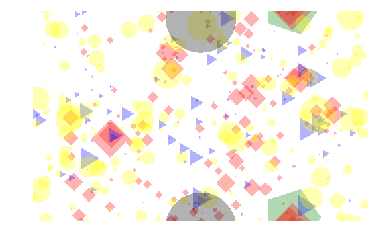

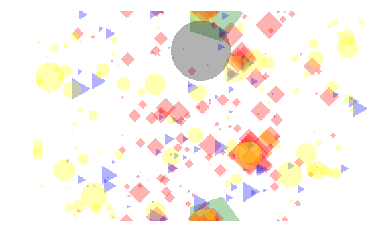

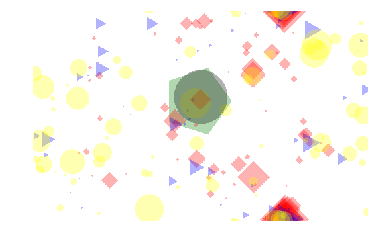

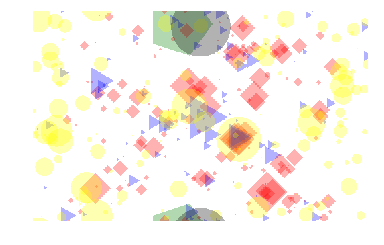

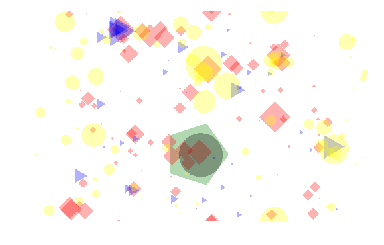

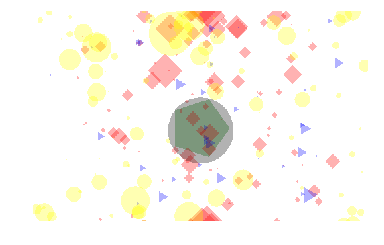

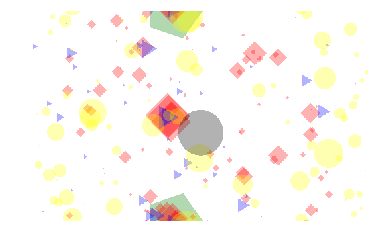

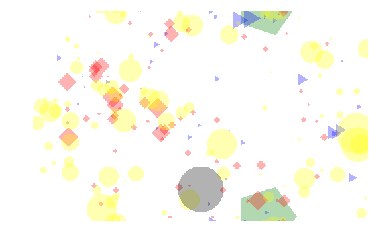

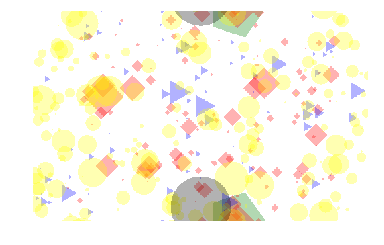

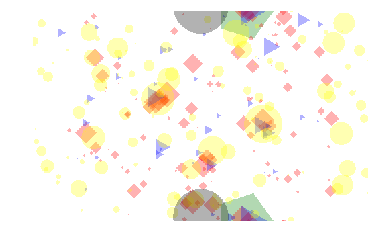

In [21]:
for x in test_images:
    data = np.asarray(x.image)
    img = create3D(data)
    showImage(img)